### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)



In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACKING_V2"]="True"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"

In [9]:
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): a is number
        b (int): b is number

    Returns:
        int: a number
    """
    return a*b

def add(a:int,b:int)->int:
    """Add two numbers

    Args:
        a (int): a is number
        b (int): b is number

    Returns:
        int: a number
    """
    return a+b

def divide(a:int,b:int)->float:
    """divide two numbers

    Args:
        a (int): a is number
        b (int): b is number

    Returns:
        float: a float number
    """
    
    return a/b

In [10]:
tools=[arxiv,wiki,add,multiply,divide]

In [11]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [12]:
tavily.invoke("Provide me the recent flight tradegy that happened in india")

[{'title': 'Air India Plane Crash 2025: Full Timeline, Cause & Impact',
  'url': 'https://www.iasexpress.net/air-india-plane-crash-2025/',
  'content': "The Air India Flight AI-171 crash on June 12, 2025, stands as one of the deadliest aviation tragedies in India's history. Shortly after takeoff from Ahmedabad en route to London, the Boeing 787 Dreamliner plummeted into a residential and institutional area, killing 265 people, including almost everyone on board and several on the ground. The aircraft erupted into flames upon impact",
  'score': 0.80771893},
 {'title': "India's Worst Air Accidents: A Timeline of Major Aviation Disasters",
  'url': 'https://www.deshabhimani.com/deshabhimani-english-/national-76192/india-air-crash-history-major-aviation-disasters-26299',
  'content': "Over the decades, the country has witnessed several aviation tragedies—from runway overruns in heavy rain to mid-air collisions—resulting in heavy loss of lives and triggering changes in safety protocols. He

In [13]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [14]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mf13w9f8b', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 208, 'prompt_tokens': 484, 'total_tokens': 692, 'completion_time': 0.504214341, 'prompt_time': 0.028576999, 'queue_time': 0.26103228, 'total_time': 0.53279134}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--82a23b6f-9420-4c79-9482-5ed8ab772a5e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'mf13w9f8b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 484, 'output_tokens': 208, 'total_tokens': 692})

In [16]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'ffc14yfrw',
  'type': 'tool_call'}]

In [17]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

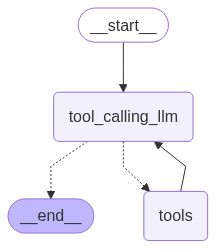

In [18]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [20]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the recent flight tradegy in india,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the recent flight tradegy in india,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (3kj8g881k)
 Call ID: 3kj8g881k
  Args:
    query: recent flight tragedy in india
  add (xwgy76f82)
 Call ID: xwgy76f82
  Args:
    a: 5
    b: 5
  multiply (ceae5bh0c)
 Call ID: ceae5bh0c
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "List of accidents and incidents involving airliners in India", "url": "https://en.wikipedia.org/wiki/List_of_accidents_and_incidents_involving_airliners_in_India", "content": "| June 12, 2025 | Air India Flight 171, a Boeing 787-8 Dreamliner en route to Gatwick, London carrying 230 passengers and 12 crew members, crashed in a building in a suburb of Ahmedabad less th

In [21]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (g3f5j6bkf)
 Call ID: g3f5j6bkf
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

Machine learning (ML) is a branch of ar